# UNET SEGMENTATION TRAINER

## Architecture

<img src="images/u-net-architecture.png"/>

<h3>Our UNet Architecture</h3>
<ol>
    <li>Contracting/Downsampling Path</li>
    <li>Bottleneck</li>
    <li>Expanding/Upsampling Path</li>
</ol>

<h3>Downsampling Path: </h3> 
<ol>
    <li>3x3 convolutions + (ReLU)</li> 
    <li>3x3 convolutions + (ReLU)</li>
    <li>2x2 max pooling + 2px padding (to mantain image size)</li>
    <li>At each downsampling step we double the number of feature channels.</li>
</ol>

<h3>Upsampling Path: </h3> 
<ol>
    <li>2x2 up-convolution + 2px padding (to mantain image size)</li>
    <li>concatenate with same level filters</li>
    <li>3x3 convolutions + (ReLU)</li> 
    <li>3x3 convolutions + (ReLU)</li>
</ol>

<h3> Final Layer: </h3>
<ol>
    <li>1x1 convolution</li>
</ol>

## Imports

In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

## Define image randomizer

In [2]:
def preprocess_for_train(image):
    
    # Random contrast
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=random.uniform(1,3), tileGridSize=(4,4))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    distorted_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    return distorted_image

## Data Generator

In [3]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, path2, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.path2 = path2
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        
        image_path = os.path.join(self.path, id_name)

        mask_path = os.path.join(self.path2, id_name[:-4] + "_segmentation.png")
        
        ## Reading Images
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.image_size, self.image_size))
        image = preprocess_for_train(image)
        
        ## Reading Masks
        mask = cv2.imread(mask_path, -1)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = np.expand_dims(mask, axis=-1)
        mask = np.maximum(mask, mask)
        
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def __getitemname__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        name = []
        
        for id_name in files_batch:
            name.append(id_name)
        
        return name

    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [4]:
image_size = 256

#select dataset:
sel_dat = "Dataset_compressed_256"
#sel_dat = "Dataset_compressed_512"
#sel_dat = "Dataset_compressed_1024"
#sel_dat = "Dataset_Nei"

train_path = "dataset/" + sel_dat + "/Segmentazione/ISIC2018_Task1-2_Training_Input"
gt_path = "dataset/" + sel_dat + "/Segmentazione/ISIC2018_Task1_Training_GroundTruth"
epochs = 150
batch_size = 24

## Training Ids
train_ids = next(os.walk(train_path))
train_ids = train_ids[2:][0]
random.shuffle(train_ids)

## Validation Data Size
val_data_size = 24*3
train_data_size = len(train_ids)-val_data_size
#train_data_size = 600

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:][:train_data_size]

print("# of training IDs: " + str(len(train_ids)))
print("# of validation IDs: " + str(len(valid_ids)))

# of training IDs: 2522
# of validation IDs: 72


In [5]:
# X is input image, Y input mask. The Data generator returns a tensor of [batch_size] images,
# with resolution [image_size], each with 3 color channels. Masks only have 1 color channel

gen = DataGen(train_ids, train_path, gt_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)

print(x.shape, y.shape)

(24, 256, 256, 3) (24, 256, 256, 1)


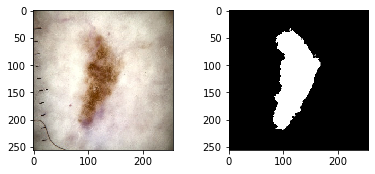

In [6]:
# display a random preprocessed image and its mask

r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## Different Convolutional Blocks

In [7]:
# See the image of the U-Net at the beginning of the file

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [8]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    #down path
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #256 -> 128
    c2, p2 = down_block(p1, f[1]) #128 -> 64
    c3, p3 = down_block(p2, f[2]) #64 -> 32
    c4, p4 = down_block(p3, f[3]) #32 -> 16
    
    #bottleneck
    bn = bottleneck(p4, f[4])
    
    #up path with concat from same level down path
    u1 = up_block(bn, c4, f[3]) #16 -> 32
    u2 = up_block(u1, c3, f[2]) #32 -> 64
    u3 = up_block(u2, c2, f[1]) #64 -> 128
    u4 = up_block(u3, c1, f[0]) #128 -> 256
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [9]:
#dice coefficient implementation
from tensorflow.keras import backend as K

smooth = 1.
# Dice Coefficient to work with Tensorflow
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Jaccard Distance to work with Tensorflow

def jaccard_distance(y_true, y_pred, smooth = 1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (jac)


In [10]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc", dice_coef, jaccard_distance])
model.summary()

W0805 09:05:57.774852 140333205231424 deprecation.py:506] From /home/patrick/anaconda2/envs/tensorflow_env/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0805 09:05:58.138626 140333205231424 deprecation.py:323] From /home/patrick/anaconda2/envs/tensorflow_env/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Training the model

In [11]:
train_gen = DataGen(train_ids, train_path, gt_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, gt_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/150
105/105 [==============================] - 19s 179ms/step - loss: 0.4538 - acc: 0.7968 - dice_coef: 0.2899 - jaccard_distance: 0.8009 - val_loss: 0.3572 - val_acc: 0.8860 - val_dice_coef: 0.3645 - val_jaccard_distance: 0.8178
Epoch 2/150
105/105 [==============================] - 5s 48ms/step - loss: 0.4805 - acc: 0.8160 - dice_coef: 0.3870 - jaccard_distance: 0.8161 - val_loss: 0.3106 - val_acc: 0.8858 - val_dice_coef: 0.4522 - val_jaccard_distance: 0.8658
Epoch 3/150
105/105 [==============================] - 5s 50ms/step - loss: 0.3888 - acc: 0.8397 - dice_coef: 0.4393 - jaccard_distance: 0.8469 - val_loss: 0.3287 - val_acc: 0.8637 - val_dice_coef: 0.3694 - val_jaccard_distance: 0.8739
Epoch 4/150
105/105 [==============================] - 5s 50ms/step - loss: 0.3858 - acc: 0.8400 - dice_coef: 0.4315 - jaccard_distance: 0.8444 - val_loss: 0.2839 - val_acc: 0.9005 - val_dice_coef: 0.5055 - val_jaccard_distance: 0.8742
Epoch 5/150
105/105 [==============================] -

Epoch 36/150
105/105 [==============================] - 5s 48ms/step - loss: 0.1969 - acc: 0.9245 - dice_coef: 0.7403 - jaccard_distance: 0.9280 - val_loss: 0.1764 - val_acc: 0.9394 - val_dice_coef: 0.7475 - val_jaccard_distance: 0.9434
Epoch 37/150
105/105 [==============================] - 5s 49ms/step - loss: 0.1709 - acc: 0.9329 - dice_coef: 0.7454 - jaccard_distance: 0.9391 - val_loss: 0.1912 - val_acc: 0.9381 - val_dice_coef: 0.7129 - val_jaccard_distance: 0.9425
Epoch 38/150
105/105 [==============================] - 5s 49ms/step - loss: 0.1729 - acc: 0.9341 - dice_coef: 0.7514 - jaccard_distance: 0.9362 - val_loss: 0.1944 - val_acc: 0.9403 - val_dice_coef: 0.7630 - val_jaccard_distance: 0.9548
Epoch 39/150
105/105 [==============================] - 5s 49ms/step - loss: 0.1585 - acc: 0.9372 - dice_coef: 0.7807 - jaccard_distance: 0.9432 - val_loss: 0.2012 - val_acc: 0.9282 - val_dice_coef: 0.7325 - val_jaccard_distance: 0.9278
Epoch 40/150
105/105 [==============================

Epoch 105/150
105/105 [==============================] - 6s 59ms/step - loss: 0.1597 - acc: 0.9422 - dice_coef: 0.7742 - jaccard_distance: 0.9443 - val_loss: 0.2082 - val_acc: 0.9214 - val_dice_coef: 0.6909 - val_jaccard_distance: 0.9240
Epoch 106/150
105/105 [==============================] - 6s 55ms/step - loss: 0.1115 - acc: 0.9556 - dice_coef: 0.8327 - jaccard_distance: 0.9590 - val_loss: 0.3030 - val_acc: 0.9363 - val_dice_coef: 0.8037 - val_jaccard_distance: 0.9595
Epoch 107/150
105/105 [==============================] - 6s 55ms/step - loss: 0.0602 - acc: 0.9763 - dice_coef: 0.9093 - jaccard_distance: 0.9790 - val_loss: 0.3105 - val_acc: 0.9347 - val_dice_coef: 0.7979 - val_jaccard_distance: 0.9599
Epoch 108/150
105/105 [==============================] - 6s 55ms/step - loss: 0.0400 - acc: 0.9829 - dice_coef: 0.9341 - jaccard_distance: 0.9849 - val_loss: 0.4066 - val_acc: 0.9410 - val_dice_coef: 0.8203 - val_jaccard_distance: 0.9660
Epoch 109/150
105/105 [=========================

## Testing the model

In [12]:
## Save the Weights
model.save_weights("UNetW-"+ str(image_size)+".h5")

## Dataset for prediction
x1, y1 = valid_gen.__getitem__(0)
name = valid_gen.__getitemname__(0)

xout = x1;
yout = y1;

for x in range(1,len(valid_gen)):
    xout = np.concatenate((xout, valid_gen.__getitem__(x)[0]))
    yout = np.concatenate((yout, valid_gen.__getitem__(x)[1]))
    name += valid_gen.__getitemname__(x)

result = model.predict(xout)
tmp = [];

for i in range(0, len(result)):
    tmp.append(cv2.threshold(result[i], 0.5, 1, cv2.THRESH_BINARY)[1])

result = tmp

In [ ]:
op_kernel = np.ones((10,10),np.uint8)
cl_kernel = np.ones((20,20),np.uint8)

for i in range(0,len(result)):
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.set_size_inches(25, 10.5)
    
    ax = fig.add_subplot(1, 4, 1)
    ax.imshow(xout[i])
    ax.imshow(np.reshape(yout[i], (image_size, image_size)), cmap='gray', alpha=0.5) # interpolation='none'
    ax.set_title(name[i] + " img + gnd truth")
    
    ax = fig.add_subplot(1, 4, 2)
    ax.imshow(np.reshape(result[i], (image_size, image_size)), cmap="gray")
    ax.set_title("Predicted mask")
    
    ax = fig.add_subplot(1, 4, 3)
    mod_img = cv2.morphologyEx(result[i], cv2.MORPH_OPEN, op_kernel)
    mod_img = cv2.morphologyEx(mod_img, cv2.MORPH_CLOSE, cl_kernel)
    #mod_img = mod_img > 0.5
    ax.imshow(xout[i])
    ax.imshow(np.reshape(mod_img, (image_size, image_size)), alpha=0.5)
    ax.set_title("Img + Post processed predicted mask")
    
    ax = fig.add_subplot(1, 4, 4)
    ax.imshow((1 + np.reshape(yout[i], (image_size, image_size))-np.reshape(mod_img, (image_size, image_size)))/2, cmap="gray", vmin=0, vmax=1)
    ax.set_title("Diff gnd truth, predicted mask")